In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
from PIL import Image
import os

In [4]:
# 🚀 Step 3: Load Flickr30K Dataset from Local Path
# ==========================
dataset_path = "Flickr30K"  # Change this to your dataset folder path
dataset = load_dataset("imagefolder", data_dir=dataset_path)


Resolving data files:   0%|          | 0/31014 [00:00<?, ?it/s]

Computing checksums:  38%|###8      | 11938/31014 [00:05<00:07, 2387.24it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
# ✅ Limit to 500 images
dataset["train"] = dataset["train"].select(range(500))

In [6]:
# ==========================
# 🚀 Step 4: Load BLIP Processor & Model
# ==========================
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


C:\Users\ACER\OneDrive\Desktop\SmartCaption\myenv310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# ==========================
# 🚀 Step 5: Define Image Preprocessing
# ==========================
from PIL import Image

def preprocess_function(example):
    if isinstance(example["image"], Image.Image):  # Check if it's already an image
        image = example["image"]
    else:
        image = Image.open(example["image"]).convert("RGB")  # Load image if it's a path

    encoding = processor(images=image, text=example["text"], return_tensors="pt", padding="max_length", truncation=True)

    return {
        "pixel_values": encoding["pixel_values"].squeeze(),
        "input_ids": encoding["input_ids"].squeeze(),
        "attention_mask": encoding["attention_mask"].squeeze(),
        "labels": encoding["input_ids"].squeeze()
    }

# ✅ Apply preprocessing
dataset = dataset.map(preprocess_function)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

KeyError: 'text'

In [9]:
print(dataset.column_names)


{'train': ['image']}


In [2]:
from datasets import load_dataset

dataset_path = "Flickr30K"  # Change this to your image dataset folder
dataset = load_dataset("imagefolder", data_dir=dataset_path)

print(dataset)  # Check structure


Resolving data files:   0%|          | 0/31014 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 31014
    })
})


In [3]:
import pandas as pd

captions_path = "flickr30k_captions.csv"  # Update with correct path
captions_df = pd.read_csv(captions_path)

print(captions_df.head())  # Preview CSV


         filename                                            caption
0  1000092795.jpg  Two young guys with shaggy hair look at their ...
1  1000092795.jpg  Two young, White males are outside near many b...
2  1000092795.jpg    Two men in green shirts are standing in a yard.
3  1000092795.jpg        A man in a blue shirt standing in a garden.
4  1000092795.jpg             Two friends enjoy time spent together.


In [4]:
# Group captions by filename
grouped_captions = captions_df.groupby("filename")["caption"].apply(list).to_dict()

def add_captions(example):
    image_name = example["image"].filename.split("/")[-1]  # Extract filename
    example["text"] = grouped_captions.get(image_name, ["No caption available"])  # Assign all captions
    return example

dataset = dataset.map(add_captions)

In [5]:
print(dataset["train"][0])  # Print first sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x25F87347E80>, 'text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.']}


In [24]:
from transformers import BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


C:\Users\ACER\OneDrive\Desktop\SmartCaption\myenv310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
[codecarbon INFO @ 16:49:59] Energy consumed for RAM : 0.000193 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 16:49:59] Energy consumed for all GPUs : 0.006366 kWh. Total GPU Power : 5.336 W
[codecarbon INFO @ 16:49:59] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:49:59] 0.007977 kWh of electricity used since the beginning.


In [25]:
import torch
from transformers import AutoTokenizer, AutoProcessor

# Load processor & tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  

subset_dataset = dataset["train"].select(range(500))  # Select first 500 samples

def preprocess_function(example):
    # Convert image to tensor
    image_tensor = processor(images=example["image"], return_tensors="pt")["pixel_values"][0]

    # Tokenize text properly
    text_encoding = tokenizer(example["text"], return_tensors="pt", padding="max_length", truncation=True)

    return {
        "pixel_values": image_tensor,  
        "input_ids": text_encoding["input_ids"][0],  # ✅ FIXED: Removes batch dim
        "attention_mask": text_encoding["attention_mask"][0],  # ✅ FIXED
        "labels": text_encoding["input_ids"][0]  # ✅ FIXED
    }

# Apply transformation
subset_dataset = subset_dataset.map(preprocess_function)

# Set PyTorch format
subset_dataset.set_format(type="torch", columns=["pixel_values", "input_ids", "attention_mask", "labels"])

# 🔥 Check output
sample = subset_dataset[0]
print(type(sample["pixel_values"]))  # ✅ Should be <class 'torch.Tensor'>
print(sample["pixel_values"].shape)  # ✅ Should be (3, 224, 224)
print(sample["input_ids"].shape)     # ✅ Should be (512,)  ← **Fixed shape**


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

[codecarbon INFO @ 16:50:14] Energy consumed for RAM : 0.000218 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 16:50:14] Energy consumed for all GPUs : 0.006384 kWh. Total GPU Power : 4.406000000000001 W
[codecarbon INFO @ 16:50:14] Energy consumed for all CPUs : 0.001595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:50:14] 0.008197 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:29] Energy consumed for RAM : 0.000242 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 16:50:30] Energy consumed for all GPUs : 0.009504 kWh. Total GPU Power : 749.673 W
[codecarbon INFO @ 16:50:30] Energy consumed for all CPUs : 0.001781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:50:30] 0.011526 kWh of electricity used since the beginning.


<class 'torch.Tensor'>
torch.Size([3, 384, 384])
torch.Size([512])


[codecarbon INFO @ 16:50:44] Energy consumed for RAM : 0.000265 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 16:50:44] Energy consumed for all GPUs : 0.009522 kWh. Total GPU Power : 4.566 W
[codecarbon INFO @ 16:50:44] Energy consumed for all CPUs : 0.001949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:50:44] 0.011737 kWh of electricity used since the beginning.


In [36]:
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Custom collator to handle images + text
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [example["input_ids"] for example in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        [example["attention_mask"] for example in batch],
        batch_first=True,
        padding_value=0
    )
    
    labels = input_ids.clone()  # Assuming labels are same as input_ids
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

# ✅ Use DataLoader for manual training
train_dataloader = DataLoader(subset_dataset, batch_size=4, collate_fn=collate_fn)

# ✅ Use DataCollatorWithPadding (instead of raw collate_fn) for Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# ✅ Update Trainer to use the correct data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_dataset,
    tokenizer=tokenizer,  
    data_collator=data_collator,  # ✅ FIXED: Trainer expects a DataCollator
)

trainer.train()


[codecarbon INFO @ 17:02:37] [setup] RAM Tracking...
[codecarbon INFO @ 17:02:37] [setup] GPU Tracking...
[codecarbon INFO @ 17:02:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:02:38] [setup] CPU Tracking...
[codecarbon WARNING @ 17:02:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:02:41] We saw that you have a 12th Gen Intel(R) Core(TM) i5-12450H but we don't know it. Please contact us.
[codecarbon INFO @ 17:02:41] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i5-12450H
[codecarbon INFO @ 17:02:41] >>> Tracker's metadata:
[codecarbon INFO @ 17:02:41]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 17:02:41]   Python version: 3.10.0
[codecarbon INFO @ 17:02:41]   CodeCarbon version: 2.2.3
[codecarbon INFO @ 17:02:41]   Available RAM : 15.711 GB
[codecarbon INFO @ 17:02:41]   CPU count: 12
[codecarbon INFO @ 17:02:41]   CPU model: 12th Gen Intel(R) Core(TM) i5-12450H
[codecarbon INFO @ 17:02:41]

Step,Training Loss


[codecarbon INFO @ 17:03:29] Energy consumed for RAM : 0.001225 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 17:03:29] Energy consumed for all GPUs : 0.003425 kWh. Total GPU Power : 31.758000000000003 W
[codecarbon INFO @ 17:03:29] Energy consumed for all CPUs : 0.008869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:29] 0.013519 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:30] Energy consumed for RAM : 0.001127 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 17:03:30] Energy consumed for all GPUs : 0.003440 kWh. Total GPU Power : 31.114000000000004 W
[codecarbon INFO @ 17:03:30] Energy consumed for all CPUs : 0.008151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:30] 0.012718 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:30] Energy consumed for RAM : 0.001515 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 17:03:30] Energy consumed for all GPUs : 0.013073 kWh. Total GPU Power : 31.561 W
[codec

KeyboardInterrupt: 

In [37]:
model.eval()  # Switch to inference mode


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [43]:
from PIL import Image
import torch

# Load test image
image_path = "C:\\Users\\ACER\\OneDrive\\Desktop\\SmartCaption\\flickr30k\\1000919630.jpg"  # Change to your actual image
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Move to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}


[codecarbon INFO @ 19:04:49] Energy consumed for RAM : 0.013117 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:04:49] Energy consumed for all GPUs : 0.054428 kWh. Total GPU Power : 5.371 W
[codecarbon INFO @ 19:04:49] Energy consumed for all CPUs : 0.094811 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:49] 0.162356 kWh of electricity used since the beginning.


In [44]:
# Generate caption
with torch.no_grad():
    output = model.generate(**inputs)

# Decode output text
caption = processor.tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Caption:", caption)


[codecarbon INFO @ 19:04:51] Energy consumed for RAM : 0.013412 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:04:51] Energy consumed for all GPUs : 0.064072 kWh. Total GPU Power : 5.521 W
[codecarbon INFO @ 19:04:51] Energy consumed for all CPUs : 0.096929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:51] 0.174413 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:51] Energy consumed for RAM : 0.013023 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:04:51] Energy consumed for all GPUs : 0.054454 kWh. Total GPU Power : 5.855 W
[codecarbon INFO @ 19:04:51] Energy consumed for all CPUs : 0.094097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:51] 0.161574 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:53] Energy consumed for RAM : 0.011969 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:04:53] Energy consumed for all GPUs : 0.051260 kWh. Total GPU Power : 29.175000000000004 W
[codecarbon INFO @ 1

Generated Caption: a man in a black shirt is holding a white dog in his arms while sitting on a chair


[codecarbon INFO @ 19:05:04] Energy consumed for RAM : 0.013141 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:04] Energy consumed for all GPUs : 0.054450 kWh. Total GPU Power : 5.243 W
[codecarbon INFO @ 19:05:04] Energy consumed for all CPUs : 0.094988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:04] 0.162580 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:06] Energy consumed for RAM : 0.013437 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:06] Energy consumed for all GPUs : 0.064094 kWh. Total GPU Power : 5.248 W
[codecarbon INFO @ 19:05:06] Energy consumed for all CPUs : 0.097106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:06] 0.174637 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:06] Energy consumed for RAM : 0.013047 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:06] Energy consumed for all GPUs : 0.054476 kWh. Total GPU Power : 5.248 W
[codecarbon INFO @ 19:05:06] Ener

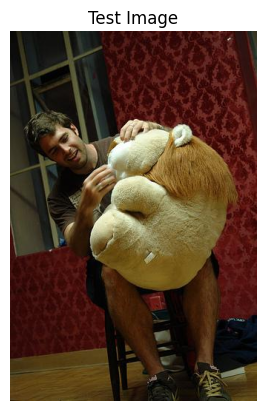

[codecarbon INFO @ 19:05:49] Energy consumed for RAM : 0.013214 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:49] Energy consumed for all GPUs : 0.054506 kWh. Total GPU Power : 5.194 W
[codecarbon INFO @ 19:05:49] Energy consumed for all CPUs : 0.095519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:49] 0.163239 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:51] Energy consumed for RAM : 0.013510 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:51] Energy consumed for all GPUs : 0.064164 kWh. Total GPU Power : 5.227 W
[codecarbon INFO @ 19:05:51] Energy consumed for all CPUs : 0.097637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:51] 0.175312 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:51] Energy consumed for RAM : 0.013121 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:05:51] Energy consumed for all GPUs : 0.054546 kWh. Total GPU Power : 5.227 W
[codecarbon INFO @ 19:05:51] Ener

In [45]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.title("Test Image")
plt.show()


In [46]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_blip")

# Save the processor
processor.save_pretrained("./fine_tuned_blip")


[]

[codecarbon INFO @ 19:06:34] Energy consumed for RAM : 0.013288 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:06:35] Energy consumed for all GPUs : 0.054570 kWh. Total GPU Power : 5.0600000000000005 W
[codecarbon INFO @ 19:06:35] Energy consumed for all CPUs : 0.096051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:35] 0.163908 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:36] Energy consumed for RAM : 0.013584 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:06:36] Energy consumed for all GPUs : 0.064236 kWh. Total GPU Power : 5.01 W
[codecarbon INFO @ 19:06:36] Energy consumed for all CPUs : 0.098169 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:36] 0.175989 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:36] Energy consumed for RAM : 0.013195 kWh. RAM Power : 5.891781806945801 W
[codecarbon INFO @ 19:06:36] Energy consumed for all GPUs : 0.054618 kWh. Total GPU Power : 5.01 W
[codecarbon INFO @ 19: